In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import laspy, lazrs

In [19]:
file_path = os.path.join("data", "point_cloud.laz")
las = laspy.read(file_path)

In [21]:
points = np.vstack((las.x, las.y, las.z)).transpose()

In [22]:
print(points.shape)

(11162018, 3)


In [62]:
points[0]

array([-1.23322132e+07,  4.63765895e+06,  1.36827000e+03])

In [63]:
len = 500
n = points.shape[0]
test = points[[i * len for i in range(int(n / len))],]

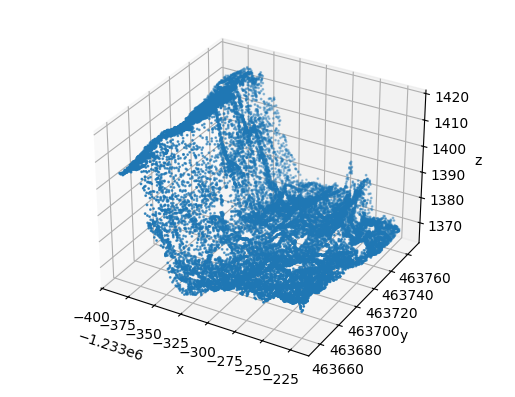

In [61]:
fig, ax = plt.subplots()
ax.axis("off")
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(test[:, 0], test[:, 1], test[:, 2], s = 1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xax
plt.show()